In [18]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
from geopy.distance import geodesic as GD
from collections import Counter
import math
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
import matplotlib.path as mpath
from scipy.stats import gaussian_kde
from matplotlib import cm
import pandas as pd
import matplotlib as mpl
from datetime import datetime, timedelta
import xarray as xr
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.ticker as ticker
import random
from matplotlib.patches import Rectangle
from scipy.stats import ttest_ind
from plotnine import *
from plotnine import ggsave
plt.rcParams['font.family'] = 'Times New Roman'

# A B

In [7]:
real_address = '../../data/Same_ET_ST_result/Network3_SC_in_out.h5'

f_real = h5py.File(real_address,'r')
SC_ij = f_real['SC_ij'][:]
SC_ji = f_real['SC_ji'][:]
lat = f_real['lat'][:]
lon = f_real['lon'][:]
f_real.close()

real_address = '../../data/Same_ET_ST_result/Network3_SC.h5'

f_real = h5py.File(real_address,'r')
dis = f_real['dis'][:]
f_real.close()

in_degree = np.zeros((73,144))
out_degree = np.zeros((73,144))

for m in range (0,73,1):
    for n in range (0,144,1):

        in_degree_value = 0
        out_degree_value = 0

        for p in range (0,73,1):
            for q in range (0,144,1):
                if SC_ij[m,n,p,q] == 0:
                    continue
                else:
                    if dis[m,n,p,q]<=4000:
                        in_degree_value += SC_ji[m,n,p,q]*np.cos(lat[p]*np.pi/180)
                        out_degree_value += SC_ij[m,n,p,q]*np.cos(lat[p]*np.pi/180)

                    else:
                        continue
        in_degree[m,n] = in_degree_value
        out_degree[m,n] = out_degree_value

In [8]:
divergence = out_degree-in_degree

In [9]:
real_address = '../../data/Same_ET_ST_result/Network3_SC_in_out.h5'

f_real = h5py.File(real_address,'r')
SC_ij = f_real['SC_ij'][:]
SC_ji = f_real['SC_ji'][:]
lat = f_real['lat'][:]
lon = f_real['lon'][:]
f_real.close()

real_address = '../../data/Same_ET_ST_result/Network3_SC.h5'

f_real = h5py.File(real_address,'r')
dis = f_real['dis'][:]
asy = f_real['asy'][:]
f_real.close()


def out_weighted_direction(SC_ij,SC_ji,asy,dis):

    x_axes = np.zeros((len(lat),len(lon)))
    y_axes = np.zeros((len(lat),len(lon)))

    for m in range(0,(len(lat)),1):
        for n in range (0,(len(lon)),1):

            outk = np.array([0,0])

            for p in range(0,(len(lat)),1):
                for q in range (0,(len(lon)),1):

                    if SC_ij[m,n,p,q] == 0:
                        continue
                    else:
                        if dis[m,n,p,q] <= 4000:
                            if asy[m,n,p,q]>0:

                                lat_diff = lat[p] - lat[m]
                                lon_diff = (lon[q] - lon[n] + 180) % 360 - 180
                                eij = np.array([lon_diff,lat_diff])
                                e_1 = eij/np.linalg.norm(eij)

                                outk = outk + (SC_ij[m,n,p,q]-SC_ji[m,n,p,q])*np.cos(lat[p]*np.pi/180)*e_1
                            else:
                                continue                        
                        else:
                            continue               

            x_axes[m][n] = outk[0]
            y_axes[m][n] = outk[1]
    
    return x_axes,y_axes

def in_weighted_direction(SC_ij,SC_ji,asy,dis):

    x_axes = np.zeros((len(lat),len(lon)))
    y_axes = np.zeros((len(lat),len(lon)))

    for m in range(0,(len(lat)),1):
        for n in range (0,(len(lon)),1):

            ink = np.array([0,0])

            for p in range(0,(len(lat)),1):
                for q in range (0,(len(lon)),1):

                    if SC_ij[m,n,p,q] == 0:
                        continue
                    else:
                        if dis[m,n,p,q] <= 4000:
                            if asy[m,n,p,q]<0:

                                lat_diff = lat[p] - lat[m]
                                lon_diff = (lon[q] - lon[n] + 180) % 360 - 180
                                eij = np.array([lon_diff,lat_diff])
                                e_1 = eij/np.linalg.norm(eij)

                                ink = ink + (SC_ji[m,n,p,q]-SC_ij[m,n,p,q])*np.cos(lat[p]*np.pi/180)*(-e_1)
                            else:
                                continue                        
                        else:
                            continue               

            x_axes[m][n] = ink[0]
            y_axes[m][n] = ink[1]
    
    return x_axes,y_axes

In [10]:
V_out_x,V_out_y = out_weighted_direction(SC_ij,SC_ji,asy,dis)
V_in_x,V_in_y = in_weighted_direction(SC_ij,SC_ji,asy,dis)

C:\Users\34322\AppData\Local\Temp\ipykernel_32852\1938455919.py:17: UserWarning: Rasterization of '<cartopy.mpl.contour.GeoContourSet object at 0x00000260B798D850>' will be ignored


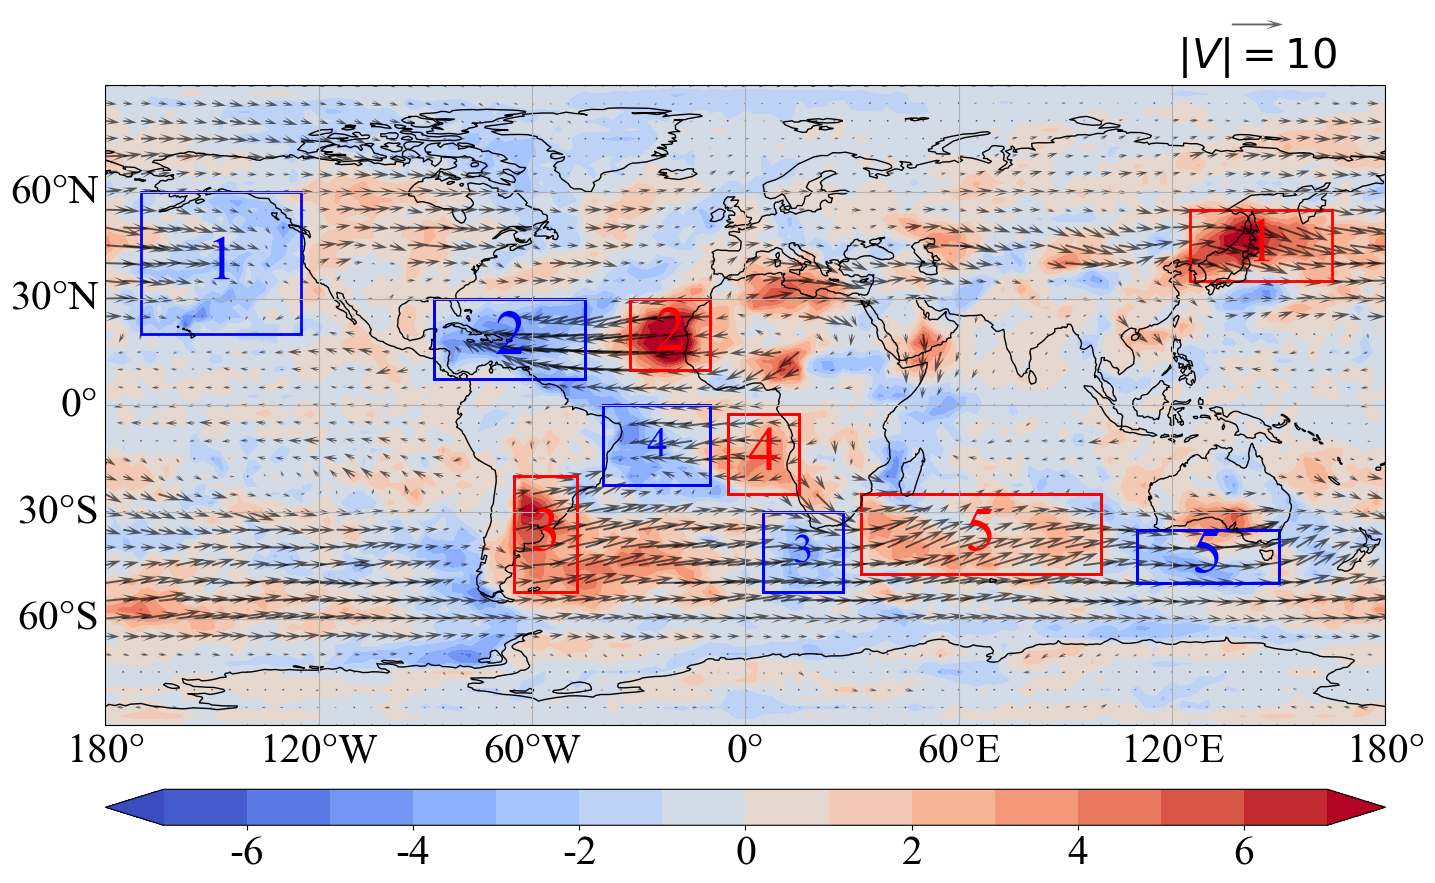

In [11]:
plt.rcParams['font.family'] = 'Times New Roman'

fig = plt.figure(figsize=(16,12))
ax1 = fig.add_axes([0.1, 0.1, 0.8, 0.6],projection = ccrs.PlateCarree())
ax1.add_feature(cfeature.COASTLINE.with_scale('110m'))
gl = ax1.gridlines(draw_labels=True,x_inline=False, y_inline=False)
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 30}
gl.ylabel_style = {'size': 30}

cyclic_data,cyclic_lon = add_cyclic_point(divergence,coord=lon)
c1 = ax1.contourf(cyclic_lon,lat,cyclic_data,cmap=cm.coolwarm,levels = np.linspace(-8,8,15),extend = 'both',transform = ccrs.PlateCarree())
colorbar = fig.add_axes([0.1,0.05,0.8,0.03])
cbar = fig.colorbar(c1,cax=colorbar,orientation='horizontal',format = '%d') 
cbar.ax.tick_params(labelsize=30)
c1.set_rasterized(True)

q1 = ax1.quiver(lon[::2],lat[::2],V_out_x[::2,::2],V_out_y[::2,::2],scale=250,transform=ccrs.PlateCarree(),width=0.0015,color='black',
                headwidth=5,headlength = 9,headaxislength = 5,alpha=0.6)

#for i in range (0,len(lat),3):
#    for j in range (0,len(lon),3):
#       start_lat = lat[i]-V_in_y[i,j]
#       start_lon = lon[j]-V_in_x[i,j]
#       q2=ax1.quiver(start_lon,start_lat,V_in_x[i,j],V_in_y[i,j],scale=200,transform=ccrs.PlateCarree(),width=0.0015,color='#4069FE')

ax1.quiverkey(q1, 0.9, 1.095, 10, label =  r"$|V|=10$",labelpos='S',coordinates='axes',fontproperties={'size': 30})
#ax1.quiverkey(q2, 0.73, 1.095, 10, label = r"$|V^{in}|=10$",labelpos='S',coordinates='axes',fontproperties={'size': 30})
ax1.set_title(' \n \n \n ')

#---------------------------------------------------------------------------------------------------------------------------------
source1_min_lon = 125
source1_max_lon = 165
source1_min_lat = 35
source1_max_lat = 55

center_lon = (source1_min_lon + source1_max_lon) / 2
center_lat = (source1_min_lat + source1_max_lat) / 2

rect = Rectangle((source1_min_lon, source1_min_lat), source1_max_lon - source1_min_lon, source1_max_lat - source1_min_lat,
                 fill=False, edgecolor='red', linewidth=2, transform=ccrs.PlateCarree())
ax1.add_patch(rect)
text = '1'
ax1.text(center_lon, center_lat, text, color='red', fontsize=45, ha='center', va='center', transform=ccrs.PlateCarree())

#--------------------------------------------------------------------------------------------------------------------------------------
sink1_min_lon = -170
sink1_max_lon = -125
sink1_min_lat = 20
sink1_max_lat = 60

center_lon = (sink1_min_lon + sink1_max_lon) / 2
center_lat = (sink1_min_lat + sink1_max_lat) / 2

rect = Rectangle((sink1_min_lon, sink1_min_lat), sink1_max_lon - sink1_min_lon, sink1_max_lat - sink1_min_lat,
                 fill=False, edgecolor='blue', linewidth=2, transform=ccrs.PlateCarree())
ax1.add_patch(rect)
text = '1'
ax1.text(center_lon, center_lat, text, color='blue', fontsize=45, ha='center', va='center', transform=ccrs.PlateCarree())
#---------------------------------------------------------------------------------------------------------------------------------------
source2_min_lon = -32.5  
source2_max_lon = -10
source2_min_lat = 10
source2_max_lat = 30 

rect = Rectangle((source2_min_lon, source2_min_lat), source2_max_lon - source2_min_lon, source2_max_lat - source2_min_lat,
                 fill=False, edgecolor='red', linewidth=2, transform=ccrs.PlateCarree())
ax1.add_patch(rect)

center_lon = (source2_min_lon + source2_max_lon) / 2
center_lat = (source2_min_lat + source2_max_lat) / 2

ax1.add_patch(rect)
text = '2'
ax1.text(center_lon, center_lat, text, color='red', fontsize=45, ha='center', va='center', transform=ccrs.PlateCarree())

#------------------------------------------------------------------------------------------------------------------------------------------
sink2_min_lon = -87.5
sink2_max_lon = -45
sink2_min_lat = 7.5
sink2_max_lat = 30

rect = Rectangle((sink2_min_lon, sink2_min_lat), sink2_max_lon - sink2_min_lon, sink2_max_lat - sink2_min_lat,
                 fill=False, edgecolor='blue', linewidth=2, transform=ccrs.PlateCarree())
ax1.add_patch(rect)

center_lon = (sink2_min_lon + sink2_max_lon) / 2
center_lat = (sink2_min_lat + sink2_max_lat) / 2

ax1.add_patch(rect)
text = '2'
ax1.text(center_lon, center_lat, text, color='blue', fontsize=45, ha='center', va='center', transform=ccrs.PlateCarree())

#--------------------------------------------------------------------------------------------------------------------------------------------

source3_min_lon = -65
source3_max_lon = -47.5
source3_min_lat = -52.5
source3_max_lat = -20

rect = Rectangle((source3_min_lon, source3_min_lat), source3_max_lon - source3_min_lon, source3_max_lat - source3_min_lat,
                 fill=False, edgecolor='red', linewidth=2, transform=ccrs.PlateCarree())
ax1.add_patch(rect)

center_lon = (source3_min_lon + source3_max_lon) / 2
center_lat = (source3_min_lat + source3_max_lat) / 2

ax1.add_patch(rect)
text = '3'
ax1.text(center_lon, center_lat, text, color='red', fontsize=45, ha='center', va='center', transform=ccrs.PlateCarree())
#-----------------------------------------------------------------------------------------------------------------------------------------------
sink3_min_lon = 5
sink3_max_lon = 27.5
sink3_min_lat = -52.5
sink3_max_lat = -30

rect = Rectangle((sink3_min_lon, sink3_min_lat), sink3_max_lon - sink3_min_lon, sink3_max_lat - sink3_min_lat,
                 fill=False, edgecolor='blue', linewidth=2, transform=ccrs.PlateCarree())
ax1.add_patch(rect)

center_lon = (sink3_min_lon + sink3_max_lon) / 2
center_lat = (sink3_min_lat + sink3_max_lat) / 2

ax1.add_patch(rect)
text = '3'
ax1.text(center_lon, center_lat, text, color='blue', fontsize=30, ha='center', va='center', transform=ccrs.PlateCarree())

#----------------------------------------------------------------------------------------------------------------------------------------------

source4_min_lon = 15
source4_max_lon = -5
source4_min_lat = -25
source4_max_lat = -2.5

rect = Rectangle((source4_min_lon, source4_min_lat), source4_max_lon - source4_min_lon, source4_max_lat - source4_min_lat,
                 fill=False, edgecolor='red', linewidth=2, transform=ccrs.PlateCarree())
ax1.add_patch(rect)

center_lon = (source4_min_lon + source4_max_lon) / 2
center_lat = (source4_min_lat + source4_max_lat) / 2

ax1.add_patch(rect)
text = '4'
ax1.text(center_lon, center_lat, text, color='red', fontsize=45, ha='center', va='center', transform=ccrs.PlateCarree())

#----------------------------------------------------------------------------------------------------------------------------------------------
sink4_min_lon = -40
sink4_max_lon = -10
sink4_min_lat = -22.5
sink4_max_lat = 0

rect = Rectangle((sink4_min_lon, sink4_min_lat), sink4_max_lon - sink4_min_lon, sink4_max_lat - sink4_min_lat,
                 fill=False, edgecolor='blue', linewidth=2, transform=ccrs.PlateCarree())
ax1.add_patch(rect)

center_lon = (sink4_min_lon + sink4_max_lon) / 2
center_lat = (sink4_min_lat + sink4_max_lat) / 2

ax1.add_patch(rect)
text = '4'
ax1.text(center_lon, center_lat, text, color='blue', fontsize=30, ha='center', va='center', transform=ccrs.PlateCarree())

#----------------------------------------------------------------------------------------------------------------------------------------------
source5_min_lon = 32.5 
source5_max_lon = 100
source5_min_lat = -47.5
source5_max_lat = -25

rect = Rectangle((source5_min_lon, source5_min_lat), source5_max_lon - source5_min_lon, source5_max_lat - source5_min_lat,
                 fill=False, edgecolor='red', linewidth=2, transform=ccrs.PlateCarree())
ax1.add_patch(rect)

center_lon = (source5_min_lon + source5_max_lon) / 2
center_lat = (source5_min_lat + source5_max_lat) / 2

ax1.add_patch(rect)
text = '5'
ax1.text(center_lon, center_lat, text, color='red', fontsize=45, ha='center', va='center', transform=ccrs.PlateCarree())
#-----------------------------------------------------------------------------------------------------------------------------------------------
sink5_min_lon = 110
sink5_max_lon = 150
sink5_min_lat = -50
sink5_max_lat = -35

rect = Rectangle((sink5_min_lon, sink5_min_lat), sink5_max_lon - sink5_min_lon, sink5_max_lat - sink5_min_lat,
                 fill=False, edgecolor='blue', linewidth=2, transform=ccrs.PlateCarree())
ax1.add_patch(rect)

center_lon = (sink5_min_lon + sink5_max_lon) / 2
center_lat = (sink5_min_lat + sink5_max_lat) / 2

ax1.add_patch(rect)
text = '5'
ax1.text(center_lon, center_lat, text, color='blue', fontsize=45, ha='center', va='center', transform=ccrs.PlateCarree())
plt.savefig("FIG/FIG3/FIG3b.svg", bbox_inches='tight', dpi=400, transparent=True)
plt.show()

# C D E F G

## 散度

In [12]:
def divergence_change(lat_array,lon_array,divergenc_array,type):

    if type == 'out':
        div_change = []
        for i in range (len(lat_array)):
            for j in range (len(lon_array)):
                p,q = np.argmax(lat == lat_array[i]),np.argmax(lon == lon_array[j])
                if divergenc_array[p][q] > 0:
                    div_change.append(divergenc_array[p][q])
                else:
                    continue
    if type == 'in':
        div_change = []
        for i in range (len(lat_array)):
            for j in range (len(lon_array)):
                p,q = np.argmax(lat == lat_array[i]),np.argmax(lon == lon_array[j])
                if divergenc_array[p][q] < 0:
                    div_change.append(abs(divergenc_array[p][q]))
                else:
                    continue

    return  div_change

In [13]:
def divergence_percentile(lat_array,lon_array,divergenc_array1,divergence_array2,type):

    if type == 'out':
        div1 = []
        div2 = []
        for i in range (len(lat_array)):
            for j in range (len(lon_array)):
                p,q = np.argmax(lat == lat_array[i]),np.argmax(lon == lon_array[j])
                if divergenc_array1[p][q] > 0:
                    div1.append(divergenc_array1[p][q])
                if divergence_array2[p][q] > 0:
                    div2.append(divergence_array2[p][q])
        percentile_change = (np.mean(np.array(div2))-np.mean(np.array(div1)))/np.mean(np.array(div1))

    if type == 'in':
        div1 = []
        div2 = []
        for i in range (len(lat_array)):
            for j in range (len(lon_array)):
                p,q = np.argmax(lat == lat_array[i]),np.argmax(lon == lon_array[j])
                if divergenc_array1[p][q] < 0:
                    div1.append(abs(divergenc_array1[p][q]))
                if divergence_array2[p][q] < 0:
                    div2.append(abs(divergence_array2[p][q]))
        percentile_change = (np.mean(np.array(div2))-np.mean(np.array(div1)))/np.mean(np.array(div1))

    return  percentile_change

In [14]:
real_address = '../../data/Same_ET_ST_result/Network3_SC_in_out.h5'

f_real = h5py.File(real_address,'r')
SC_ij = f_real['SC_ij'][:]
SC_ji = f_real['SC_ji'][:]
lat = f_real['lat'][:]
lon = f_real['lon'][:]
f_real.close()

real_address = '../../data/Same_ET_ST_result/Network3_SC.h5'

f_real = h5py.File(real_address,'r')
dis = f_real['dis'][:]
f_real.close()

in_degree = np.zeros((73,144))
out_degree = np.zeros((73,144))

for m in range (0,73,1):
    for n in range (0,144,1):

        in_degree_value = 0
        out_degree_value = 0

        for p in range (0,73,1):
            for q in range (0,144,1):
                if SC_ij[m,n,p,q] == 0:
                    continue
                else:
                    if dis[m,n,p,q]<=4000:
                        in_degree_value += SC_ji[m,n,p,q]*np.cos(lat[p]*np.pi/180)
                        out_degree_value += SC_ij[m,n,p,q]*np.cos(lat[p]*np.pi/180)

                    else:
                        continue
        in_degree[m,n] = in_degree_value
        out_degree[m,n] = out_degree_value

network3_divergence = out_degree-in_degree

In [15]:
real_address = '../../data/Same_ET_ST_result/Network2_SC_in_out.h5'

f_real = h5py.File(real_address,'r')
SC_ij = f_real['SC_ij'][:]
SC_ji = f_real['SC_ji'][:]
lat = f_real['lat'][:]
lon = f_real['lon'][:]
f_real.close()

real_address = '../../data/Same_ET_ST_result/Network2_SC.h5'

f_real = h5py.File(real_address,'r')
dis = f_real['dis'][:]
f_real.close()

in_degree = np.zeros((73,144))
out_degree = np.zeros((73,144))

for m in range (0,73,1):
    for n in range (0,144,1):

        in_degree_value = 0
        out_degree_value = 0

        for p in range (0,73,1):
            for q in range (0,144,1):
                if SC_ij[m,n,p,q] == 0:
                    continue
                else:
                    if dis[m,n,p,q]<=4000:
                        in_degree_value += SC_ji[m,n,p,q]*np.cos(lat[p]*np.pi/180)
                        out_degree_value += SC_ij[m,n,p,q]*np.cos(lat[p]*np.pi/180)

                    else:
                        continue
        in_degree[m,n] = in_degree_value
        out_degree[m,n] = out_degree_value

network2_divergence = out_degree-in_degree

In [16]:
area1_Network2_sink = divergence_change(np.arange(20,61,2.5),np.arange(-170,-124,2.5),network2_divergence,'in')
area1_Network3_sink = divergence_change(np.arange(20,61,2.5),np.arange(-170,-124,2.5),network3_divergence,'in')

area2_Network2_sink = divergence_change(np.arange(7.5,31,2.5),np.arange(-87.5,-44,2.5),network2_divergence,'in')
area2_Network3_sink = divergence_change(np.arange(7.5,31,2.5),np.arange(-87.5,-44,2.5),network3_divergence,'in')

area3_Network2_sink = divergence_change(np.arange(-52.5,-29,2.5),np.arange(5,28,2.5),network2_divergence,'in')
area3_Network3_sink = divergence_change(np.arange(-52.5,-29,2.5),np.arange(5,28,2.5),network3_divergence,'in')


area4_Network2_sink = divergence_change(np.arange(-22.5,1,2.5),np.arange(-40,-9,2.5),network2_divergence,'in')
area4_Network3_sink = divergence_change(np.arange(-22.5,1,2.5),np.arange(-40,-9,2.5),network3_divergence,'in')

area5_Network2_sink = divergence_change(np.arange(-50,-34,2.5),np.arange(110,151,2.5),network2_divergence,'in')
area5_Network3_sink = divergence_change(np.arange(-50,-34,2.5),np.arange(110,151,2.5),network3_divergence,'in')

In [17]:
area1_Network2_source = divergence_change(np.arange(35,56,2.5),np.arange(125,166,2.5),network2_divergence,'out')
area1_Network3_source = divergence_change(np.arange(35,56,2.5),np.arange(125,166,2.5),network3_divergence,'out')

area2_Network2_source = divergence_change(np.arange(10,31,2.5),np.arange(-32.5,-9,2.5),network2_divergence,'out')
area2_Network3_source = divergence_change(np.arange(10,31,2.5),np.arange(-32.5,-9,2.5),network3_divergence,'out')

area3_Network2_source = divergence_change(np.arange(-52.5,-19,2.5),np.arange(-65,-47,2.5),network2_divergence,'out')
area3_Network3_source = divergence_change(np.arange(-52.5,-19,2.5),np.arange(-65,-47,2.5),network3_divergence,'out')

area4_Network2_source = divergence_change(np.arange(-25,-2,2.5),np.arange(-5,16,2.5),network2_divergence,'out')
area4_Network3_source = divergence_change(np.arange(-25,-2,2.5),np.arange(-5,16,2.5),network3_divergence,'out')

area5_Network2_source = divergence_change(np.arange(-47.5,-24,2.5),np.arange(32.5,100,2.5),network2_divergence,'out')
area5_Network3_source = divergence_change(np.arange(-47.5,-24,2.5),np.arange(32.5,100,2.5),network3_divergence,'out')

In [38]:
d1 = np.array(area5_Network2_sink)
d2 = np.array(area5_Network3_sink)
min_value = min(np.min(d1),np.min(d2))

T, P = ttest_ind(d1, d2, equal_var=False)

categories = ['Period 1']*d1.shape[0] + ['Period 2']*d2.shape[0]

df = pd.DataFrame({
    'category': categories,
     r"$-D$": np.concatenate((d1, d2)),
})

# #FFA38F red
# #96C9F4 blue

colors = ['#96C9F4']*d1.shape[0] + ['#96C9F4']*d2.shape[0]

p = (
    ggplot(df, aes(x='category', y=r"$-D$", fill='category')) +
    geom_violin(aes(fill='category', color='category'), position=position_nudge(x=0), trim=False, adjust=2, alpha=0.2, size=1) +
    geom_boxplot(aes(fill='category', color='category'), width=0.2, position=position_nudge(x=0), size=1, outlier_alpha=0.5) +

    theme(
        legend_position="none",
        panel_spacing_x=10, figure_size=(6,5),
        #aspect_ratio=0.7,
        axis_text_x=element_text(family='Times New Roman', size=35, color='#000000', rotation=0),
        axis_text_y=element_text(family='Times New Roman', size=35, color='#000000', rotation=0),
        axis_title_y=element_text(family='Times New Roman', size=35, rotation=90),
        axis_title=element_blank(),  # Remove axis titles
        panel_grid_major=element_blank(),   # Remove major grid lines
        panel_grid_minor=element_blank(),   # Remove minor grid lines
        panel_background=element_blank(),   # Remove panel background
        axis_line=element_line(color='black', size=1),
        axis_ticks_major=element_line(color='black', size=1),  # Set the thickness of the major ticks
        axis_ticks_length_major=6  # Set the length of the major ticks
    ) +

    scale_fill_manual(values=['#C3E1F9', '#C3E1F9']) +
    scale_color_manual(values=['#3FA2F6', '#3FA2F6']) +

    scale_y_continuous(limits=(min_value,8), breaks=range(0,9,2)) +

    #FEDAE3  C3E1F9
    #C80036  3FA2F6

    annotate('text', x=1.5, y=8, label="Sink 5", ha='center', size=30, color='black',family='Times New Roman') +
    annotate('text', x=1.5, y=8* 0.9, label=f"T: {T:.2f}", ha='center', size=25, color='black',family='Times New Roman') +
    annotate('text', x=1.5, y=8* 0.8, label=f"P: {P:.3f}", ha='center', size=25, color='black',family='Times New Roman')
  
    #annotate('text', x=1.5, y=15, label="Source 2", ha='center', size=30, color='black',family='Times New Roman') +
    #annotate('text', x=1.5, y=15*0.9, label=f"T: {T:.2f}", ha='center', size=25, color='black',family='Times New Roman') +
    #annotate('text', x=1.5, y=15*0.8, label=f"P: {P:.3f}", ha='center', size=25, color='black',family='Times New Roman') 

    
)

p.draw()

p.save(
    filename="FIG/FIG3/FIG3g2.svg",  # 保存路径
    dpi=400,                       # 分辨率
    bbox_inches='tight',
    transparent=True                      # 去除多余边距
)

d:\miniconda\envs\py311\Lib\site-packages\plotnine\ggplot.py:606: PlotnineWarning: Saving 6 x 5 in image.
d:\miniconda\envs\py311\Lib\site-packages\plotnine\ggplot.py:607: PlotnineWarning: Filename: FIG/FIG3/FIG3g2.svg


In [40]:
area1_sink_change = divergence_percentile(np.arange(20,61,2.5),np.arange(-170,-124,2.5),
                                      network2_divergence,network3_divergence,'in')
area2_sink_change = divergence_percentile(np.arange(7.5,31,2.5),np.arange(-87.5,-44,2.5),
                                      network2_divergence,network3_divergence,'in')
area3_sink_change = divergence_percentile(np.arange(-52.5,-29,2.5),np.arange(5,28,2.5),
                                      network2_divergence,network3_divergence,'in')
area4_sink_change = divergence_percentile(np.arange(-22.5,1,2.5),np.arange(-40,-9,2.5),
                                      network2_divergence,network3_divergence,'in')
area5_sink_change = divergence_percentile(np.arange(-50,-34,2.5),np.arange(110,151,2.5),
                                      network2_divergence,network3_divergence,'in')

print(area1_sink_change,area2_sink_change,area3_sink_change,area4_sink_change,area5_sink_change)

0.3596802853047782 0.2600823925097178 0.8272969933654578 -0.05326066371582583 0.23854015177798424


In [41]:
area1_source_change = divergence_percentile(np.arange(35,56,2.5),np.arange(125,166,2.5),
                                        network2_divergence,network3_divergence,'out')
area2_source_change = divergence_percentile(np.arange(10,31,2.5),np.arange(-32.5,-9,2.5),
                                        network2_divergence,network3_divergence,'out')
area3_source_change = divergence_percentile(np.arange(-52.5,-19,2.5),np.arange(-65,-47,2.5),
                                        network2_divergence,network3_divergence,'out')
area4_source_change = divergence_percentile(np.arange(-25,-2,2.5),np.arange(-5,16,2.5),
                                        network2_divergence,network3_divergence,'out')
area5_source_change = divergence_percentile(np.arange(-47.5,-24,2.5),np.arange(32.5,100,2.5),
                                        network2_divergence,network3_divergence,'out')

print(area1_source_change,area2_source_change,area3_source_change,area4_source_change,area5_source_change)

1.5674649950744042 0.6925685576400122 0.2808433530794893 0.09399714219930566 -0.14996994000415395


## 向量长度

In [ ]:
def compute_V_len(lat_array,lon_array,V_x,V_y):
    V_len = []

    for i in range (len(lat_array)):
        for j in range (len(lon_array)):
            p,q = np.argmax(lat == lat_array[i]),np.argmax(lon == lon_array[j])
            V_len.append(np.sqrt(V_x[p][q]**2+V_y[p][q]**2))

    return V_len

In [13]:
def out_weighted_direction(SC_ij,SC_ji,asy,dis):

    x_axes = np.zeros((len(lat),len(lon)))
    y_axes = np.zeros((len(lat),len(lon)))

    for m in range(0,(len(lat)),1):
        for n in range (0,(len(lon)),1):

            outk = np.array([0,0])

            for p in range(0,(len(lat)),1):
                for q in range (0,(len(lon)),1):

                    if SC_ij[m,n,p,q] == 0:
                        continue
                    else:
                        if dis[m,n,p,q] <= 4000:
                            if asy[m,n,p,q]>0:

                                lat_diff = lat[p] - lat[m]
                                lon_diff = (lon[q] - lon[n] + 180) % 360 - 180
                                eij = np.array([lon_diff,lat_diff])
                                e_1 = eij/np.linalg.norm(eij)

                                outk = outk + (SC_ij[m,n,p,q]-SC_ji[m,n,p,q])*np.cos(lat[p]*np.pi/180)*e_1
                            else:
                                continue                        
                        else:
                            continue               

            x_axes[m][n] = outk[0]
            y_axes[m][n] = outk[1]
    
    return x_axes,y_axes

def in_weighted_direction(SC_ij,SC_ji,asy,dis):

    x_axes = np.zeros((len(lat),len(lon)))
    y_axes = np.zeros((len(lat),len(lon)))

    for m in range(0,(len(lat)),1):
        for n in range (0,(len(lon)),1):

            ink = np.array([0,0])

            for p in range(0,(len(lat)),1):
                for q in range (0,(len(lon)),1):

                    if SC_ij[m,n,p,q] == 0:
                        continue
                    else:
                        if dis[m,n,p,q] <= 4000:
                            if asy[m,n,p,q]<0:

                                lat_diff = lat[p] - lat[m]
                                lon_diff = (lon[q] - lon[n] + 180) % 360 - 180
                                eij = np.array([lon_diff,lat_diff])
                                e_1 = eij/np.linalg.norm(eij)

                                ink = ink + (SC_ji[m,n,p,q]-SC_ij[m,n,p,q])*np.cos(lat[p]*np.pi/180)*(-e_1)
                            else:
                                continue                        
                        else:
                            continue               

            x_axes[m][n] = ink[0]
            y_axes[m][n] = ink[1]
    
    return x_axes,y_axes

In [14]:
real_address = '../../data/Same_ET_ST_result/Network2_SC_in_out.h5'

f_real = h5py.File(real_address,'r')
SC_ij = f_real['SC_ij'][:]
SC_ji = f_real['SC_ji'][:]
lat = f_real['lat'][:]
lon = f_real['lon'][:]
f_real.close()

real_address = '../../data/Same_ET_ST_result/Network2_SC.h5'

f_real = h5py.File(real_address,'r')
dis = f_real['dis'][:]
asy = f_real['asy'][:]
f_real.close()

V_out_x_P2,V_out_y_P2 = out_weighted_direction(SC_ij,SC_ji,asy,dis)
V_in_x_P2,V_in_y_P2 = in_weighted_direction(SC_ij,SC_ji,asy,dis)

In [15]:
real_address = '../../data/Same_ET_ST_result/Network3_SC_in_out.h5'

f_real = h5py.File(real_address,'r')
SC_ij = f_real['SC_ij'][:]
SC_ji = f_real['SC_ji'][:]
lat = f_real['lat'][:]
lon = f_real['lon'][:]
f_real.close()

real_address = '../../data/Same_ET_ST_result/Network3_SC.h5'

f_real = h5py.File(real_address,'r')
dis = f_real['dis'][:]
asy = f_real['asy'][:]
f_real.close()

V_out_x_P3,V_out_y_P3 = out_weighted_direction(SC_ij,SC_ji,asy,dis)
V_in_x_P3,V_in_y_P3 = in_weighted_direction(SC_ij,SC_ji,asy,dis)

In [16]:
area1_Network2_sink = compute_V_len(np.arange(20,61,2.5),np.arange(-170,-124,2.5),V_in_x_P2,V_in_y_P2)
area1_Network3_sink = compute_V_len(np.arange(20,61,2.5),np.arange(-170,-124,2.5),V_in_x_P3,V_in_y_P3)

area2_Network2_sink = compute_V_len(np.arange(7.5,31,2.5),np.arange(-87.5,-44,2.5),V_in_x_P2,V_in_y_P2)
area2_Network3_sink = compute_V_len(np.arange(7.5,31,2.5),np.arange(-87.5,-44,2.5),V_in_x_P3,V_in_y_P3)

area3_Network2_sink = compute_V_len(np.arange(-52.5,-29,2.5),np.arange(5,28,2.5),V_in_x_P2,V_in_y_P2)
area3_Network3_sink = compute_V_len(np.arange(-52.5,-29,2.5),np.arange(5,28,2.5),V_in_x_P3,V_in_y_P3)


area4_Network2_sink = compute_V_len(np.arange(-22.5,1,2.5),np.arange(-40,-9,2.5),V_in_x_P2,V_in_y_P2)
area4_Network3_sink = compute_V_len(np.arange(-22.5,1,2.5),np.arange(-40,-9,2.5),V_in_x_P3,V_in_y_P3)

area5_Network2_sink = compute_V_len(np.arange(-50,-34,2.5),np.arange(110,151,2.5),V_in_x_P2,V_in_y_P2)
area5_Network3_sink = compute_V_len(np.arange(-50,-34,2.5),np.arange(110,151,2.5),V_in_x_P3,V_in_y_P3)

In [59]:
area1_Network2_source = compute_V_len(np.arange(35,56,2.5),np.arange(125,166,2.5),V_out_x_P2,V_out_y_P2)
area1_Network3_source = compute_V_len(np.arange(35,56,2.5),np.arange(125,166,2.5),V_out_x_P3,V_out_y_P3)

area2_Network2_source = compute_V_len(np.arange(10,31,2.5),np.arange(-32.5,-9,2.5),V_out_x_P2,V_out_y_P2)
area2_Network3_source = compute_V_len(np.arange(10,31,2.5),np.arange(-32.5,-9,2.5),V_out_x_P3,V_out_y_P3)

area3_Network2_source = compute_V_len(np.arange(-52.5,-19,2.5),np.arange(-65,-52,2.5),V_out_x_P2,V_out_y_P2)
area3_Network3_source = compute_V_len(np.arange(-52.5,-19,2.5),np.arange(-65,-52,2.5),V_out_x_P3,V_out_y_P3)

area4_Network2_source = compute_V_len(np.arange(-25,-2,2.5),np.arange(-5,16,2.5),V_out_x_P2,V_out_y_P2)
area4_Network3_source = compute_V_len(np.arange(-25,-2,2.5),np.arange(-5,16,2.5),V_out_x_P3,V_out_y_P3)

area5_Network2_source = compute_V_len(np.arange(-47.5,-24,2.5),np.arange(32.5,100,2.5),V_out_x_P2,V_out_y_P2)
area5_Network3_source = compute_V_len(np.arange(-47.5,-24,2.5),np.arange(32.5,100,2.5),V_out_x_P3,V_out_y_P3)

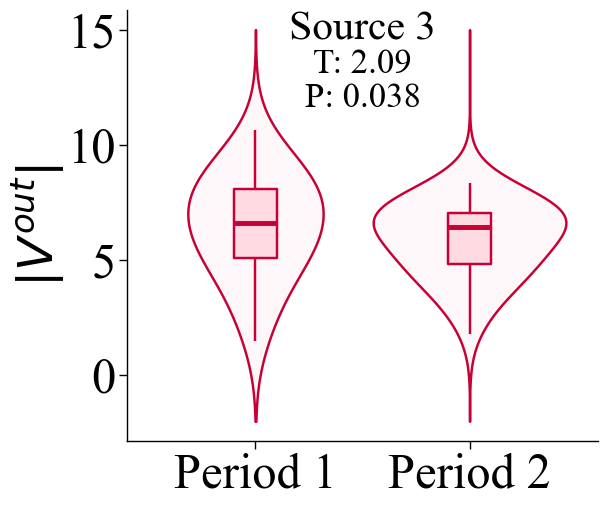

In [60]:
d1 = np.array(area3_Network2_source)
d2 = np.array(area3_Network3_source)

T, P = ttest_ind(d1, d2, equal_var=False)

categories = ['Period 1']*d1.shape[0] + ['Period 2']*d2.shape[0]

df = pd.DataFrame({
    'category': categories,
     r"$|V^{out}|$": np.concatenate((d1, d2)),
})

# #FFA38F red
# #96C9F4 blue

colors = ['#FFA38F']*d1.shape[0] + ['#FFA38F']*d2.shape[0]

p = (
    ggplot(df, aes(x='category', y=r"$|V^{out}|$", fill='category')) +
    geom_violin(aes(fill='category', color='category'), position=position_nudge(x=0), trim=False, adjust=2, alpha=0.2, size=1) +
    geom_boxplot(aes(fill='category', color='category'), width=0.2, position=position_nudge(x=0), size=1, outlier_alpha=0.5) +

    theme(
        legend_position="none",
        panel_spacing_x=10, figure_size=(6,5),
        #aspect_ratio=0.7,
        axis_text_x=element_text(family='Times New Roman', size=35, color='#000000', rotation=0),
        axis_text_y=element_text(family='Times New Roman', size=35, color='#000000', rotation=0),
        axis_title_y=element_text(family='Times New Roman', size=35, rotation=90),
        axis_title=element_blank(),  # Remove axis titles
        panel_grid_major=element_blank(),   # Remove major grid lines
        panel_grid_minor=element_blank(),   # Remove minor grid lines
        panel_background=element_blank(),   # Remove panel background
        axis_line=element_line(color='black', size=1),
        axis_ticks_major=element_line(color='black', size=1),  # Set the thickness of the major ticks
        axis_ticks_length_major=6  # Set the length of the major ticks
    ) +

    scale_fill_manual(values=['#FEDAE3', '#FEDAE3']) +
    scale_color_manual(values=['#C80036', '#C80036']) +

    #FEDAE3  C3E1F9
    #C80036  3FA2F6

    #annotate('text', x=1.5, y=13, label="Sink 5", ha='center', size=30, color='black',family='Times New Roman') +
    #annotate('text', x=1.5, y=13* 0.9, label=f"T: {T:.2f}", ha='center', size=25, color='black',family='Times New Roman') +
    #annotate('text', x=1.5, y=13* 0.8, label=f"P: {P:.3f}", ha='center', size=25, color='black',family='Times New Roman') +
    #ylim(-2,13) 
  
    annotate('text', x=1.5, y= 15, label="Source 3", ha='center', size=30, color='black',family='Times New Roman') +
    annotate('text', x=1.5, y=15*0.9, label=f"T: {T:.2f}", ha='center', size=25, color='black',family='Times New Roman') +
    annotate('text', x=1.5, y=15*0.8, label=f"P: {P:.3f}", ha='center', size=25, color='black',family='Times New Roman') +
    ylim(-2,15) 
    
)

p.draw()